In [ ]:
!pip install selfies exmol tensorflow tensorflowjs kdeepensemble tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 2.0 MB/s 
     |████████████████████████████████| 22.7 MB 1.4 MB/s 
     |████████████████████████████████| 462 kB 82.6 MB/s 
     |████████████████████████████████| 40 kB 5.6 MB/s 
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5908 sha256=fae842437a9f1df0b18d71060df8df1e480786e818029691c43b875bf2462b3a
  Stored in directory: /root/.cache/pip/wheels/5d/c2/23/4915cca200175fece0d5015f1981f4e1ecb5e3ef40b66cf525
Successfully built ratelimit
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
from tqdm.notebook import tqdm
import urllib
from dataclasses import dataclass
import json
import kdens
from rdkit import Chem
import random

import pandas as pd
import exmol
import selfies as sf

np.random.seed(0)
tf.config.optimizer.set_jit(True)
tf.random.set_seed(0)
random.seed(0)

import pandas as pd
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   
           })

print(kdens.__version__)

0.3.2


In [ ]:
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
# shuffle here to remove ordering
soldata = soldata.sample(frac=1).reset_index(drop=True)
soldata.head()


,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,B-4206,diuron,InChI=1S/C9H10Cl2N2O/c1-13(2)9(14)12-6-3-4-7(1...,XMTQQYYKAHVGBJ-UHFFFAOYSA-N,CN(C)C(=O)Nc1ccc(Cl)c(Cl)c1,-3.744300,1.227164,5,G4,233.098,...,1.0,76.0,1.0,0.0,0.0,1.0,32.34,92.603980,2.781208,352.665233
1,F-988,7-(3-amino-3-methylazetidin-1-yl)-8-chloro-1-c...,InChI=1S/C17H17ClFN3O3/c1-17(20)6-21(7-17)14-1...,DUNZFXZSFJLIKR-UHFFFAOYSA-N,CC1(N)CN(C2=C(Cl)C3=C(C=C2F)C(=O)C(C(=O)O)=CN3...,-5.330000,0.000000,1,G1,365.792,...,3.0,132.0,2.0,2.0,2.0,4.0,88.56,147.136366,2.001398,973.487509
2,C-1996,4-acetoxybiphenyl; 4-biphenylyl acetate,InChI=1S/C14H12O2/c1-11(15)16-14-9-7-13(8-10-1...,MISFQCBPASYYGV-UHFFFAOYSA-N,CC(=O)OC1=CC=C(C=C1)C2=CC=CC=C2,-4.400000,0.000000,1,G1,212.248,...,2.0,80.0,2.0,0.0,0.0,2.0,26.30,94.493449,2.228677,471.848345
3,A-3055,methane dimolybdenum,InChI=1S/CH4.2Mo/h1H4;;,JAGQSESDQXCFCH-UHFFFAOYSA-N,C.[Mo].[Mo],-3.420275,0.409223,2,G3,207.923,...,0.0,20.0,0.0,0.0,0.0,0.0,0.00,49.515427,-0.000000,2.754888
4,A-2575,ethyl 4-[[(methylphenylamino)methylene]amino]b...,InChI=1S/C17H18N2O2/c1-3-21-17(20)14-9-11-15(1...,GNGYPJUKIKDJQT-UHFFFAOYSA-N,CCOC(=O)c1ccc(cc1)N=CN(C)c2ccccc2,-5.450777,0.000000,1,G1,282.343,...,5.0,108.0,2.0,0.0,0.0,2.0,41.90,124.243431,2.028889,606.447052


In [ ]:
def randomize_smiles(mol, random_type=None, isomericSmiles=True):
    """
    From: https://github.com/rxn4chemistry/rxn_yields
    From: https://github.com/undeadpixel/reinvent-randomized and https://github.com/GLambard/SMILES-X
    Returns a random SMILES given a SMILES of a molecule.
    :param mol: A Mol object
    :param random_type: The type (unrestricted, restricted, rotated) of randomization performed.
    :return : A random SMILES string of the same molecule or None if the molecule is invalid.
    """
    if random_type is None:
      random_type = np.random.choice(['unrestricted', 'restricted', 'rotated'])

    if random_type == "unrestricted":
        return Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=isomericSmiles)
    elif random_type == "restricted":
        new_atom_order = list(range(mol.GetNumAtoms()))
        random.shuffle(new_atom_order)
        random_mol = Chem.RenumberAtoms(mol, newOrder=new_atom_order)
        return Chem.MolToSmiles(random_mol, canonical=False, isomericSmiles=isomericSmiles)
    elif random_type == 'rotated':
        n_atoms = mol.GetNumAtoms()
        rotation_index = random.randint(0, n_atoms-1)
        atoms = list(range(n_atoms))
        new_atoms_order = (atoms[rotation_index%len(atoms):]+atoms[:rotation_index%len(atoms)])
        rotated_mol = Chem.RenumberAtoms(mol,new_atoms_order)
        return Chem.MolToSmiles(rotated_mol, canonical=False, isomericSmiles=isomericSmiles)
    raise ValueError("Type '{}' is not valid".format(random_type))

aug_smiles = []
aug_labels = []

for s,l in zip(soldata.SMILES, soldata.Solubility):
  mol = Chem.MolToSmiles(Chem.MolFromSmiles(s, sanitize=True))
  if not mol:
    continue
  aug_smiles.append(s)
  aug_labels.append(l)
  for _ in range(10):
    try:
      # I think the randomization may create side-effects?
      si = randomize_smiles(Chem.MolFromSmiles(s))
    except RuntimeError:
      break
    if si is not None and si != s:
      aug_smiles.append(si)
      aug_labels.append(l)
# add water a bunch (add end, so should show up in train)
for _ in range(100):
  aug_smiles.append('O')
  aug_labels.append(np.log(55.41))
print('Before Augmentation', len(soldata.SMILES), 'After augmentation', len(aug_smiles))

Before Augmentation 9982 After augmentation 97154


In [ ]:
selfies_list = []
for s in aug_smiles:
  try:
    se = sf.encoder(s)
    selfies_list.append(se)
  except:
    selfies_list.append(None)

In [ ]:
basic = set(exmol.get_basic_alphabet())
data_vocab = set(sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None]))
vocab = ['[Nop]', '.']
vocab.extend(list(data_vocab.union(basic)))
vocab_stoi = {o:i for o,i in zip(vocab, range(len(vocab)))}

def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token in vocab_stoi:
            result.append(vocab_stoi[token])
        else:
            result.append(np.nan)
            #print('Warning')
    return result

def ints2selfies(v):
    return ''.join([vocab[i] for i in v])

# test them out
s = selfies_list[0]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
assert so == s
print('Vocab Size:', len(data_vocab))

selfies: [C][N][Branch1][C][C][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][C][Cl][C][Branch1][C][Cl][=C][Ring1][Branch2]
selfies2ints: [161, 53, 242, 161, 161, 161, 45, 161, 57, 53, 161, 62, 161, 62, 242, 161, 174, 161, 242, 161, 174, 62, 198, 65]
ints2selfes: [C][N][Branch1][C][C][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][C][Cl][C][Branch1][C][Cl][=C][Ring1][Branch2]
Vocab Size: 262


In [ ]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
    hidden_dim: int
    drop_rate: int 
    nmodels: int
    adv_epsilon: float
    epochs: int


config = Config(
    vocab_size=len(vocab),
    example_number=len(selfies_list),
    batch_size=16,
    buffer_size=10000,
    embedding_dim=64,
    hidden_dim=32,
    rnn_units=64,
    drop_rate=0.2,
    nmodels = 4,
    adv_epsilon=1e-2,
    epochs=15
)

# New Section

In [ ]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post")
aug_labels = np.array(aug_labels)
sol_values = aug_labels[[bool(s) for s in selfies_list]].astype(np.float32)

# there may be some contaimation from augmentation in one record, but is negligible
N = len(sol_values)
print(N, 'Total examples')

split = int(0.2 * N)
test_data = tf.data.Dataset.from_tensor_slices(
    (padded_seqs[:split], sol_values[:split]))

val_data = tf.data.Dataset.from_tensor_slices(
    (padded_seqs[split:2*split], sol_values[split:2*split]))

sol_values = sol_values[2*split:]
padded_seqs = padded_seqs[2 * split:]

#idx = kdens.resample(sol_values, (sol_values.shape[0], config.nmodels), nclasses=100)
# decided against adjusting since think we match real distribution of molecules already 
idx = np.random.choice(np.arange(sol_values.shape[0]), size=(sol_values.shape[0], config.nmodels))

train_data = tf.data.Dataset.from_tensor_slices(
    (padded_seqs[idx], sol_values[idx].astype(np.float32)))

test_data = test_data.batch(config.batch_size)
val_data = val_data.batch(config.batch_size).cache().prefetch(
        tf.data.AUTOTUNE
    )
train_data = train_data.shuffle(config.buffer_size).batch(config.batch_size).prefetch(
        tf.data.AUTOTUNE
    )


# force them to cache
#list(val_data.as_numpy_iterator())
#list(train_data.as_numpy_iterator())
#print('cached')

97083 Total examples


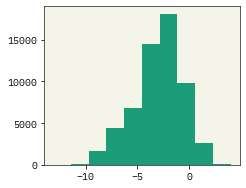

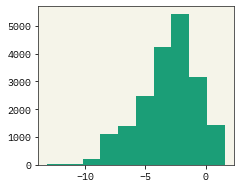

In [ ]:
plt.hist(sol_values[idx[:,0]])
plt.show()
plt.hist(sol_values[:split])
plt.show()

### Model

In [ ]:
def build_model():
    inputs = tf.keras.Input(shape=(None,))

    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)
    e = tf.keras.layers.Dropout(config.drop_rate)(e)
    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(config.rnn_units, return_sequences=True,  kernel_regularizer='l2'))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(config.rnn_units, kernel_regularizer='l2'))(x)
    #x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, kernel_regularizer='l2'))(e)
    x = tf.keras.layers.LayerNormalization()(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(config.hidden_dim, activation="swish",  kernel_regularizer='l2')(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(config.hidden_dim // 2, activation="swish",  kernel_regularizer='l2')(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    muhat = tf.keras.layers.Dense(1)(x)
    stdhat = tf.keras.layers.Dense(1, 
                                   activation='softplus', 
                                   bias_constraint=tf.keras.constraints.MinMaxNorm( 
                                       min_value=1e-6, max_value=1000.0, rate=1.0, axis=0))(x)
    out = tf.reshape(tf.stack([muhat, stdhat], axis=-1), (-1, 2))
    model = tf.keras.Model(inputs=inputs, outputs=out, name='sol-rnn')
    partial_in = tf.keras.Model(inputs=inputs, outputs=e)
    partial_out = tf.keras.Model(inputs=e, outputs=out)
    return model, partial_in, partial_out
def build_inf_model():
    inputs = tf.keras.Input(shape=(None,))

    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(config.rnn_units))(x)
    #x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(e)
    x = tf.keras.layers.LayerNormalization()(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(config.hidden_dim, activation="swish")(x)
    x = tf.keras.layers.Dense(config.hidden_dim // 2, activation="swish")(x)
    # predicting prob, so no activation
    muhat = tf.keras.layers.Dense(1)(x)
    stdhat = tf.keras.layers.Dense(1, activation='softplus')(x)
    model = tf.keras.Model(inputs=inputs, outputs=(muhat, stdhat), name='sol-rnn-infer')
    return model

In [ ]:
model = kdens.DeepEnsemble(build_model, config.nmodels, config.adv_epsilon, partial=True)
model.compile(tf.optimizers.Adam(1e-4), loss=kdens.neg_ll, metrics=['mae'])

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
result = model.fit(train_data, validation_data=val_data, epochs=config.epochs)#, callbacks=callbacks)

Epoch 1/15
3641/3641 [==============================] - 2582s 694ms/step - loss: 4.0837 - adv_loss: 4.1165 - mae: 2.0372 - val_loss: 1.4279 - val_mae: 1.7708 - val_adv_loss: 0.0000e+00
Epoch 2/15
3641/3641 [==============================] - 2515s 691ms/step - loss: 1.4569 - adv_loss: 1.4563 - mae: 1.9121 - val_loss: 1.3747 - val_mae: 1.8185 - val_adv_loss: 0.0000e+00
Epoch 3/15
3641/3641 [==============================] - 2505s 688ms/step - loss: 1.4129 - adv_loss: 1.4126 - mae: 1.8949 - val_loss: 1.3616 - val_mae: 1.8210 - val_adv_loss: 0.0000e+00
Epoch 4/15
3641/3641 [==============================] - 2511s 690ms/step - loss: 1.3949 - adv_loss: 1.3943 - mae: 1.8871 - val_loss: 1.3545 - val_mae: 1.8334 - val_adv_loss: 0.0000e+00
Epoch 5/15
3641/3641 [==============================] - 2509s 689ms/step - loss: 1.3856 - adv_loss: 1.3851 - mae: 1.8849 - val_loss: 1.3502 - val_mae: 1.8294 - val_adv_loss: 0.0000e+00
Epoch 6/15
3641/3641 [==============================] - 2507s 689ms/step - 

In [ ]:
# test water
x = np.reshape(selfies2ints('[O]' + ''.join(['[Nop]'] * 100)), (1, -1))
model(x)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-3.0033672e+00,  5.6476831e+00,  1.1016693e-03]], dtype=float32)>

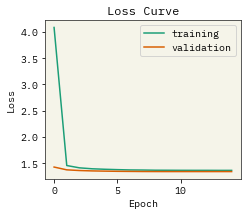

In [ ]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

In [ ]:
yhat = []
test_y = []
yvar = []
yepi = []
for x, y in tqdm(test_data):
    out = model.predict(x)
    yhat.extend(out[...,0].flatten())
    yvar.extend(out[...,1].flatten())
    yepi.extend(out[...,2].flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

  0%|          | 0/1214 [00:00<?, ?it/s]

In [ ]:
ll = np.mean(kdens.neg_ll(test_y, yhat))
metric_r = np.corrcoef(test_y, yhat)[0,1]
metric_mae = np.mean(np.abs(test_y - yhat))

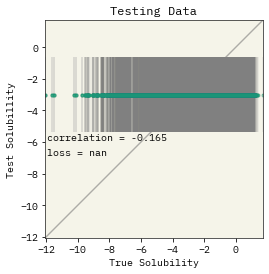

In [ ]:
#plot test data
plt.figure(figsize=(5,4))
alpha = 0.5
plt.plot(test_y, test_y, '-', color='#666', linewidth=1, zorder=0, alpha=alpha)
plt.errorbar(test_y, yhat, yerr=np.sqrt(yvar), fmt='.', color='gray', alpha=0.05 * alpha)
plt.errorbar(test_y, yhat, yerr=np.sqrt(yepi), fmt='.', color='C0', alpha=0.2 * alpha)
plt.text(min(test_y) + 0.1, max(y) - 2, f"correlation = {metric_r:.3f}")
plt.text(min(test_y) + 0.1, max(y) - 3, f"loss = {ll:.3f}")
plt.title("Testing Data")
plt.xlim(min(test_y), max(test_y))
plt.ylim(min(test_y), max(test_y))
plt.gca().set_aspect('equal')
plt.xlabel('True Solubility')
plt.ylabel('Test Solubillity')
plt.savefig("rnn-fit.png", dpi=300)
plt.show()

In [ ]:
import tensorflowjs as tfjs
import json


quantize_map = {'float16': '*'}
for i,m in enumerate(model.models):
  nm = build_inf_model()
  nm.set_weights(m.get_weights())
  # call to make sure it's built
  nm(x)
  tfjs.converters.save_keras_model(nm, f"models/{i}")
  tfjs.converters.save_keras_model(nm, f"models/{i}-q", quantization_dtype_map=quantize_map)



In [ ]:
with open('vocab.json', 'w') as f:
  json.dump(dict(vocab=vocab, vocab_stoi=vocab_stoi), f)

In [ ]:
model_card = {
    'title': 'Solubility Prediction',
    'details': 'Solubility predictor with uncertainty. Model is a bidirectional LSTM that predict standard deviation and mean. An esnemble of 5 is combined for predictions. Epistemic uncertainty comes from model disagreement.',
    'use': 'Organic molecules',
    'factors': 'Model may not generalize to large molecules, very soluble (< -12.5 logS), and highly soluble (> 1 logS), ions, or metals.',
    'metrics': f'Test correlation {metric_r:.2f}. Test MAE {metric_mae:.2f}',
    'evaluation': 'Withheld examples (test data)',
    'training': f'{len(soldata.SMILES)} molecules, which was augmented to {len(aug_smiles)} molecules.',
    'caveats': 'Check the parity plot to see where your molecule falls relative to the training curve.',
    'ethics': 'None noted',
    'image': 'https://raw.githubusercontent.com/ur-whitelab/exmol.io/main/models/rnn-fit.png'
}
with open('card.json', 'w') as f:
  json.dump(model_card, f)
print(json.dumps(model_card, indent=True))

{
 "title": "Solubility Prediction",
 "details": "Solubility predictor with uncertainty. Model is a bidirectional LSTM that predict standard deviation and mean. An esnemble of 5 is combined for predictions. Epistemic uncertainty comes from model disagreement.",
 "use": "Organic molecules",
 "factors": "Model may not generalize to large molecules, very soluble (< -12.5 logS), and highly soluble (> 1 logS), ions, or metals.",
 "metrics": "Test correlation -0.16. Test MAE 1.82",
 "evaluation": "Withheld examples (test data)",
 "training": "9982 molecules, which was augmented to 97154 molecules.",
 "caveats": "Check the parity plot to see where your molecule falls relative to the training curve.",
 "ethics": "None noted",
 "image": "https://raw.githubusercontent.com/ur-whitelab/exmol.io/main/models/rnn-fit.png"
}


In [ ]:
!zip -r sol-model.zip models/* *json rnn-fit.png
from google.colab import files
files.download( 'sol-model.zip' )

  adding: models/0/ (stored 0%)
  adding: models/0/model.json (deflated 84%)
  adding: models/0/group1-shard1of1.bin (deflated 6%)
  adding: models/0-q/ (stored 0%)
  adding: models/0-q/model.json (deflated 87%)
  adding: models/0-q/group1-shard1of1.bin (deflated 40%)
  adding: models/1/ (stored 0%)
  adding: models/1/model.json (deflated 85%)
  adding: models/1/group1-shard1of1.bin (deflated 6%)
  adding: models/1-q/ (stored 0%)
  adding: models/1-q/model.json (deflated 87%)
  adding: models/1-q/group1-shard1of1.bin (deflated 37%)
  adding: models/2/ (stored 0%)
  adding: models/2/model.json (deflated 84%)
  adding: models/2/group1-shard1of1.bin (deflated 6%)
  adding: models/2-q/ (stored 0%)
  adding: models/2-q/model.json (deflated 87%)
  adding: models/2-q/group1-shard1of1.bin (deflated 39%)
  adding: models/3/ (stored 0%)
  adding: models/3/model.json (deflated 84%)
  adding: models/3/group1-shard1of1.bin (deflated 6%)
  adding: models/3-q/ (stored 0%)
  adding: models/3-q/model.j

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>